### Hamiltonian Study - Evolution and Simulation
This notebook is intended to illustrate how to compute the energy expectation value for a quantum state that is produced using Hamiltonian consisting of multiple weighted Pauli strings.

The first section defines functions for creating a circuit with appended gates for the Hamiltonian term, executing those circuits, and computing the expectation value over all terms of the Hamiltonian.
The second section defines several simple functions for creating PauliEvolution circuits from the Hamiltonian Pault strings.
This is followed by a number of tests that evolve a Hamiltonian either classically or using a quantum evolution circuit and obtaining energy measures.
(There are several cells toward the end that are retained for bits of code that may be useful.)

In [1]:
import numpy as np
import copy
from math import sin, cos, pi
import time

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.primitives import Estimator

from qiskit.quantum_info import Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PauliEvolutionGate

import scipy as sc
import matplotlib.pyplot as plt

backend = Aer.get_backend('qasm_simulator')
#backend = Aer.get_backend('statevector_simulator')
noise_model = None

# Set numpy print options to format floating point numbers
np.set_printoptions(precision=3, suppress=True)

verbose = False

# Configure module paths
import sys
sys.path.insert(1, "_common")

# Import helper functions
import evolution_exact
import observables as obs
obs.verbose = False


### ------------------------------------------------------------------

### Define Test Hamiltonians and Initial State

In [2]:

# Return a Hamiltonian of the specified type: return terms array and SparsePauliOp equivalent
def get_hamiltonian(type: str, num_qubits: int):  
    H_terms = None
    H = None
    match type:
        case 'test-1':
            H_terms = [
                (0.5, 'ZI'),
                (0.3, 'XX'),
                (-0.1, 'YY'),
            ]
        case 'test-2':
            H_terms =  obs.swap_pauli_list([
                ('ZI', 0.5),
                ('XX', 0.3),
                ('YY', -0.1)
            ])
        case 'test-4':
            H_terms =  obs.swap_pauli_list([
                ('XXII', 0.5),
                ('IYYI', 0.3),
                ('IIZZ', 0.4),
                ('XYII', 0.2),
                ('IIYX', 0.6),
                ('IZXI', 0.1),
                ('XIII', 0.7)
            ])
        case "ising":        # the Ising Hamiltonian
            H = get_ising_hamiltonian(L=num_qubits, J=0.2, h=1.2, alpha=pi / 8)
            H_terms = obs.swap_pauli_list(H.to_list())

    if H is None:
        H = obs.convert_to_sparse_pauli_op(H_terms)

    return H_terms, H

# classical simple Ising is ZZ
# TFIM ZZ + X  is transverse field
# + longitudinal field -> ZZ, X, and Z
def get_ising_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

######## Specify the Hamiltonian to use for execution

num_qubits = 6

#H_type = "test-1"
#H_type = "test-4"
H_type = "ising"

H_terms, H = get_hamiltonian(H_type, num_qubits)
print(f"... using H_terms = {H_terms}")
print(f"    SparsePauliOp = ", H)

"""
groups = obs.group_commuting_terms(H_terms_swapped)
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    for pauli, coeff in group:
        print(f"  {pauli}: {coeff}")
"""
pass


... using H_terms = [((-0.2+0j), 'IIIIZZ'), ((-0.2+0j), 'IIIZZI'), ((-0.2+0j), 'IIZZII'), ((-0.2+0j), 'IZZIII'), ((-0.2+0j), 'ZZIIII'), ((-0.4592201188381077+0j), 'IIIIIZ'), ((-0.4592201188381077+0j), 'IIIIZI'), ((-0.4592201188381077+0j), 'IIIZII'), ((-0.4592201188381077+0j), 'IIZIII'), ((-0.4592201188381077+0j), 'IZIIII'), ((-0.4592201188381077+0j), 'ZIIIII'), ((-1.1086554390135441+0j), 'IIIIIX'), ((-1.1086554390135441+0j), 'IIIIXI'), ((-1.1086554390135441+0j), 'IIIXII'), ((-1.1086554390135441+0j), 'IIXIII'), ((-1.1086554390135441+0j), 'IXIIII'), ((-1.1086554390135441+0j), 'XIIIII')]
    SparsePauliOp =  SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j,
 -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -1.109+0.j,
 -1.109+0.j, -1.109+0.j, -1.109+0.

### Define Multiple Observables related to the Hamiltonian in List
Here we create a list, in which the first element is the 'primary' Hamiltonian and the remaining elements are additional related observables.
This list can be passed to the estimate_expectation_multiple() function which first obtains expectation values of each term in the primary Hamiltonian and then computes the total of the expectation values for each term in each observable.

In [3]:
# DEVNOTE: Currently, this only works for the specific Ising observables below

# Define additional Hamiltonian terms for other Ising observables 
H_terms_spin_correlation = [(0.2,'IIIIZZ'), (0.2,'IIIZZI'), (0.2,'IIZZII'), (0.2,'IZZIII'), (0.2,'ZZIIII')]
H_terms_magnetization = [(1,'IIIIIZ'), (1,'IIIIZI'), (1,'IIIZII'), (1,'IIZIII'), (1,'IZIIII'), (1, 'ZIIIII')]

print(H_terms_spin_correlation)
print(H_terms_magnetization)

#L = 6
L = num_qubits

print("****")
magnetization_op = SparsePauliOp.from_sparse_list(
    #[("Z", [i], 1.0) for i in range(0, 6)], num_qubits=6
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
print("magnetization: ", magnetization_op)

print("****")
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)
print("mean spin correlation", correlation_op)

H_terms_magnetization = obs.swap_pauli_list(magnetization_op.to_list())
H_terms_spin_correlation = obs.swap_pauli_list(correlation_op.to_list())

print(H_terms_spin_correlation)
print(H_terms_magnetization)

H_terms_multiple = [H_terms, H_terms_spin_correlation, H_terms_magnetization] #pass this into a function, and check if each term is in.
H_terms_names = ["Energy", "Spin Correlation", "Magnetization"]


[(0.2, 'IIIIZZ'), (0.2, 'IIIZZI'), (0.2, 'IIZZII'), (0.2, 'IZZIII'), (0.2, 'ZZIIII')]
[(1, 'IIIIIZ'), (1, 'IIIIZI'), (1, 'IIIZII'), (1, 'IIZIII'), (1, 'IZIIII'), (1, 'ZIIIII')]
****
magnetization:  SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
****
mean spin correlation SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])
[((0.2+0j), 'IIIIZZ'), ((0.2+0j), 'IIIZZI'), ((0.2+0j), 'IIZZII'), ((0.2+0j), 'IZZIII'), ((0.2+0j), 'ZZIIII')]
[((1+0j), 'IIIIIZ'), ((1+0j), 'IIIIZI'), ((1+0j), 'IIIZII'), ((1+0j), 'IIZIII'), ((1+0j), 'IZIIII'), ((1+0j), 'ZIIIII')]


### ------------------------------------------------------------------

### Define Initial State

In [4]:

# initialize 0 state based on width of first term's Pauli string
dimension = len(H_terms[0][1])
initial_state = np.zeros((2**dimension), dtype=complex)
initial_state[0] = 1  # Set the amplitude for |00> state
print(initial_state)


[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


### Perform Test 1 - Classical Evolution - Simple Single Step Test
Here, a first order approximation is computed, along with the same first order calculation done in a quantum circuit execution
This is compared to an exact classical calculation of the evolved state energy.

In [5]:
print("========= Simple Classical Calculation of Energy\n")
print(H_terms)
print(initial_state)

total_evolution_time = 0.5

# Compute the theoretical energy using an exact, but slower, classical computation
theoretical_energies_exact, time_values = evolution_exact.compute_theoretical_energies(initial_state, H, total_evolution_time, total_evolution_time)

print("")
print(f"For evolution time = {total_evolution_time}:")
print(f"  Theoretical energy (exact): {theoretical_energies_exact[0]}")
print("")


========= Simple Classical Calculation of Energy

[((-0.2+0j), 'IIIIZZ'), ((-0.2+0j), 'IIIZZI'), ((-0.2+0j), 'IIZZII'), ((-0.2+0j), 'IZZIII'), ((-0.2+0j), 'ZZIIII'), ((-0.4592201188381077+0j), 'IIIIIZ'), ((-0.4592201188381077+0j), 'IIIIZI'), ((-0.4592201188381077+0j), 'IIIZII'), ((-0.4592201188381077+0j), 'IIZIII'), ((-0.4592201188381077+0j), 'IZIIII'), ((-0.4592201188381077+0j), 'ZIIIII'), ((-1.1086554390135441+0j), 'IIIIIX'), ((-1.1086554390135441+0j), 'IIIIXI'), ((-1.1086554390135441+0j), 'IIIXII'), ((-1.1086554390135441+0j), 'IIXIII'), ((-1.1086554390135441+0j), 'IXIIII'), ((-1.1086554390135441+0j), 'XIIIII')]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0

### ------------------------------------------------------------------

### Perform Test 2 - Quantum Evolution - Calculate Exact Theoretical Energy and Time Arrays for Multiple Steps
Here, we create an array containing a series of time values for increasing longer evolution times along with the computed theoretical energy at each time step, given the initial state.  Note that the energy remains constant since these are a time-independent Hamiltonians.

In [6]:
print("========= Exact Classical Calculation of Energy and Time Arrays\n")
print(H)
print(H_terms)
print(initial_state)

# total evolution time
total_evolution_time = 6

# for Trotterized evolution, specify size of each step
step_size = 0.5

# DEVNOTE: in the code below, the compute_theoretical_energies function returns the time_values array that it created
# As we scale to more qubits, it will not be possible to compute theoretical energies,
# so we will likely want to create the time_values array independent of that function.
# time_values = ...

########### Obtain exact energies and time values for successively longer evolution times

print(f"... getting exact energies")

# Create array of theoretical energies (for comparison)
# We compute this in an array function so that we can do the matrix conversion just once for all the steps
theoretical_energies, time_values = evolution_exact.compute_theoretical_energies(initial_state, H, total_evolution_time, step_size)

print(f"\n... got exact energies {theoretical_energies}")


========= Exact Classical Calculation of Energy and Time Arrays

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j,
 -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -1.109+0.j,
 -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j])
[((-0.2+0j), 'IIIIZZ'), ((-0.2+0j), 'IIIZZI'), ((-0.2+0j), 'IIZZII'), ((-0.2+0j), 'IZZIII'), ((-0.2+0j), 'ZZIIII'), ((-0.4592201188381077+0j), 'IIIIIZ'), ((-0.4592201188381077+0j), 'IIIIZI'), ((-0.4592201188381077+0j), 'IIIZII'), ((-0.4592201188381077+0j), 'IIZIII'), ((-0.4592201188381077+0j), 'IZIIII'), ((-0.4592201188381077+0j), 'ZIIIII'), ((-1.1086554390135441+0j), 'IIIIIX'), ((-1.1086554390135441+0j), 'IIIIXI'), ((-1.1086554390135441+0j), 'IIIXII'), ((-1.1086554390135441+0j), 'IIXIII'), ((-1.1086554390135441+0j

### Perform Test 2 - Quantum Evolution - Compute Multiple Observables for Multiple Steps
Here, we populate arrays ot energy and other observables at increasing time steps using quantum circuit evolution and measurement.

In [7]:
print("========= Quantum Simulation of Evolution and Calculation of Observables\n")
print(H)
print(H_terms)
print(initial_state)

########### Obtain multiple observables for successively longer evolution times

observables_list = []

ts = time.time()

# loop over successively longer time steps to create arrays of obeservable values
# by creating an increasingly long quantum circuit and computing observables from execution results
for step in range(len(time_values)):
    print(".", end="")

    # create a quantum circuit for this step, from the first of the Hamiltonians in the first element of the array
    qc = obs.create_quantum_test_circuit(initial_state, H_terms_multiple[0], step, step_size)
    
    # Obtain all the estimated observables by executing the circuit on the backend and compute each observable
    observables = obs.estimate_expectation_multiple(backend, qc, H_terms_multiple, num_shots=10000)

    # append these observables to a list for plotting
    observables_list.append(observables)
    
print("")

print(f"... cumulative elapsed execution time = {round(time.time()-ts, 3)}")


========= Quantum Simulation of Evolution and Calculation of Observables

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j,
 -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -1.109+0.j,
 -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j])
[((-0.2+0j), 'IIIIZZ'), ((-0.2+0j), 'IIIZZI'), ((-0.2+0j), 'IIZZII'), ((-0.2+0j), 'IZZIII'), ((-0.2+0j), 'ZZIIII'), ((-0.4592201188381077+0j), 'IIIIIZ'), ((-0.4592201188381077+0j), 'IIIIZI'), ((-0.4592201188381077+0j), 'IIIZII'), ((-0.4592201188381077+0j), 'IIZIII'), ((-0.4592201188381077+0j), 'IZIIII'), ((-0.4592201188381077+0j), 'ZIIIII'), ((-1.1086554390135441+0j), 'IIIIIX'), ((-1.1086554390135441+0j), 'IIIIXI'), ((-1.1086554390135441+0j), 'IIIXII'), ((-1.1086554390135441+0j), 'IIXIII'), ((-1.1086554390

### ------------------------------------------------------------------

### Plot Results
Generate a plot showing the expectation value of multiple observables over successively longer Trotterized evolution times

C:\Users\m\.conda\envs\qiskit-test-1.2\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\m\.conda\envs\qiskit-test-1.2\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


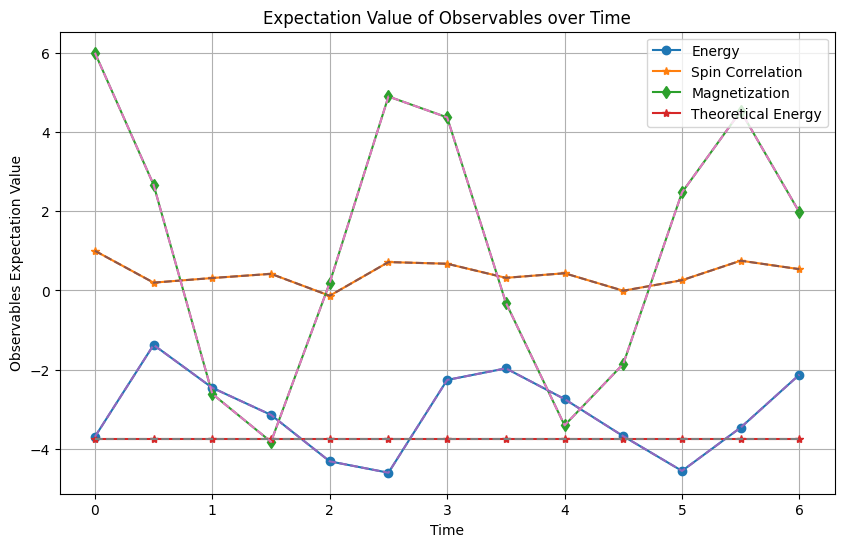

In [8]:

########### Transform Data for Plotting

observables_values_list = []

# pre-populate the observables value arrays with empty arrays
for i in range(len(H_terms_multiple)):
    observables_values_list.append([])

# for each step, put the values of the computed observables into the values array, for plotting
for step in range(len(time_values)):
    for j in range(len(observables_list[step])):
        observables_values_list[j].append(observables_list[step][j])

########### Plot Results

# Plot the results
plt.figure(figsize=(10, 6))

marker=['o', '*', 'd', '1', '2']

#####
for i in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_values_list[i], label= H_terms_names[i], marker=marker[i])

plt.plot(time_values, theoretical_energies, label='Theoretical Energy', marker='*')

#####
for j in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_values_list[j], linestyle='--')
    
plt.plot(time_values, theoretical_energies, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Observables Expectation Value')
plt.title('Expectation Value of Observables over Time')
plt.legend()
plt.grid(True)
plt.show()


### ------------------------------------------------------------------

### Test Commuting Groups Performance improvement 
Generate a plot showing the expectation value of multiple observables over successively longer Trotterized evolution times.

DEVNOTE: This version does not work yet; see CommutingTermsExample-TL for a version that works

In [9]:
"""
num_qubits = 6

#H_type = "test-1"
#H_type = "test-4"
H_type = "ising"

H_terms, H = get_hamiltonian(H_type, num_qubits)
print(f"... using H_terms = {H_terms}")
print(f"    SparsePauliOp = ", H)

H_terms_multiple = [H_terms, H_terms_spin_correlation, H_terms_magnetization] #pass this into a function, and check if each term is in.
H_terms_names = ["Energy", "Spin Correlation", "Magnetization"]

#H_terms_multiple = [H_terms, H_terms_magnetization] #pass this into a function, and check if each term is in.
#H_terms_names = ["Energy", "Magnetization"]
"""

#obs.verbose = True

step = 2
step_size = 0.5

ts = time.time()

# create a quantum circuit for this step, from the first of the Hamiltonians in the first element of the array
qc = obs.create_quantum_test_circuit(initial_state, H_terms_multiple[0], step, step_size)

# Obtain all the estimated observables by executing the circuit on the backend and compute each observable
observables = obs.estimate_expectation_multiple(backend, qc, H_terms_multiple, num_shots=10000)

print(f"... elapsed time = {round(time.time()-ts, 3)}")

print(observables)

# Get groups for original Hamiltonian
groups = obs.group_commuting_terms(obs.swap_pauli_list(H_terms))


print("\n ============= H_terms:")
print(H_terms)

print("\n ============= H_terms grouped:")
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    for coeff, pauli in group:
        print(f"  {coeff}: {pauli}")
        
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    #for pauli, coeff in group:
    for j, term in enumerate(group):
        print(f"  {pauli}: {coeff}")
        group[j] = (coeff, pauli)
        
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    for coeff, pauli in group:
        print(f"  {coeff}: {pauli}")
        


... elapsed time = 0.442
[(-2.383181889473307+0j), (0.30844+0j), (-2.6647999999999996+0j)]

 ============= H_terms:
[((-0.2+0j), 'IIIIZZ'), ((-0.2+0j), 'IIIZZI'), ((-0.2+0j), 'IIZZII'), ((-0.2+0j), 'IZZIII'), ((-0.2+0j), 'ZZIIII'), ((-0.4592201188381077+0j), 'IIIIIZ'), ((-0.4592201188381077+0j), 'IIIIZI'), ((-0.4592201188381077+0j), 'IIIZII'), ((-0.4592201188381077+0j), 'IIZIII'), ((-0.4592201188381077+0j), 'IZIIII'), ((-0.4592201188381077+0j), 'ZIIIII'), ((-1.1086554390135441+0j), 'IIIIIX'), ((-1.1086554390135441+0j), 'IIIIXI'), ((-1.1086554390135441+0j), 'IIIXII'), ((-1.1086554390135441+0j), 'IIXIII'), ((-1.1086554390135441+0j), 'IXIIII'), ((-1.1086554390135441+0j), 'XIIIII')]

 ============= H_terms grouped:
Group 1:
  IIIIZZ: (-0.2+0j)
  IIIZZI: (-0.2+0j)
  IIZZII: (-0.2+0j)
  IZZIII: (-0.2+0j)
  ZZIIII: (-0.2+0j)
  IIIIIZ: (-0.4592201188381077+0j)
  IIIIZI: (-0.4592201188381077+0j)
  IIIZII: (-0.4592201188381077+0j)
  IIZIII: (-0.4592201188381077+0j)
  IZIIII: (-0.4592201188381077